In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import scienceplots

# Set random seed for reproducibility
np.random.seed(67)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

plt.style.use(['science', 'no-latex', 'grid'])
plt.rcParams.update({'font.size':20})
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [3]:
# Get device for training
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
torch.backends.cudnn.benchmark = True

Using cuda device
Is CUDA supported by this system? True
CUDA version: 13.0


In [4]:
# Load dataset
housing = fetch_california_housing()
X, Y = housing.data, housing.target
num_classes = len(np.unique(Y))
print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {num_classes}")
print(f"Features per sample: {X.shape[1]}")

Dataset shape: (20640, 8)
Number of classes: 3842
Features per sample: 8


In [5]:
# explore dataset
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [6]:
# Data processing parameters
data_portions = (0.6,0.2,0.2)
training_portion, validation_portion, test_portion = data_portions
# Normalize
validation_portion = validation_portion / (validation_portion+training_portion)

In [7]:
# Normalize inputs
# X_mean = X.mean(axis=0)
# X_std = X.std(axis=0)
# X_normalized = (X - X_mean) / X_std

# Split into training and test sets
num_samples = X.shape[0]
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=20
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.25, random_state=20
)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

test_loader = DataLoader(list(zip(X_test, Y_test)), batch_size=32, shuffle=False, pin_memory=(device=='CUDA'))

In [8]:
class Net(nn.Module):

    def __init__(self, input_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size,8),
            nn.ReLU(),
            # nn.Linear(16,16),
            # nn.ReLU(),
            nn.Linear(8,output_size)
        )
    
    def forward(self,x):
        return self.net(x)

In [9]:
def train_model(model, X_train, Y_train, X_val, Y_val, num_epochs, learning_rate, batch_size=32):
    train_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=batch_size, shuffle=True, pin_memory=(device=='CUDA'))
    val_loader = DataLoader(list(zip(X_val, Y_val)), batch_size=batch_size, shuffle=False, pin_memory=(device=='CUDA'))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    for epoch in range(num_epochs+1):
        model.train()
        epoch_loss = 0.0
        for  inputs, labels in train_loader:
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        # Validation
        model.eval()
        val_loss = 0.0
        if epoch % 10 == 0:
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.float().to(device), labels.float().to(device)
                    outputs = model(inputs).squeeze()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            history['val_loss'].append(avg_val_loss)
            print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return history

In [10]:
# Configure model
input_size = X_train.shape[1]
output_size = 1  # Regression output

In [11]:
model = Net(input_size, output_size).to(device)

history = train_model(model, X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val, num_epochs=500, 
                      batch_size=64, learning_rate=0.001)

# Evaluate on test set
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32, device=device).view(-1, 1)
    Y_pred = model(X_test_tensor)
    test_loss = nn.MSELoss()(Y_pred, Y_test_tensor)
    print(f'Test MSE Loss: {test_loss.item():.4f}')

Epoch [0/500], Train Loss: 3.5406, Val Loss: 2.1698
Epoch [10/500], Train Loss: 0.4317, Val Loss: 0.4057
Epoch [20/500], Train Loss: 0.3884, Val Loss: 0.3730
Epoch [30/500], Train Loss: 0.3709, Val Loss: 0.3604
Epoch [40/500], Train Loss: 0.3625, Val Loss: 0.3518
Epoch [50/500], Train Loss: 0.3532, Val Loss: 0.3426
Epoch [60/500], Train Loss: 0.3456, Val Loss: 0.3336
Epoch [70/500], Train Loss: 0.3414, Val Loss: 0.3315
Epoch [80/500], Train Loss: 0.3372, Val Loss: 0.3269
Epoch [90/500], Train Loss: 0.3375, Val Loss: 0.3285
Epoch [100/500], Train Loss: 0.3369, Val Loss: 0.3251
Epoch [110/500], Train Loss: 0.3339, Val Loss: 0.3257
Epoch [120/500], Train Loss: 0.3341, Val Loss: 0.3215
Epoch [130/500], Train Loss: 0.3344, Val Loss: 0.3221
Epoch [140/500], Train Loss: 0.3318, Val Loss: 0.3215
Epoch [150/500], Train Loss: 0.3319, Val Loss: 0.3220
Epoch [160/500], Train Loss: 0.3311, Val Loss: 0.3233
Epoch [170/500], Train Loss: 0.3310, Val Loss: 0.3214
Epoch [180/500], Train Loss: 0.3298, Va

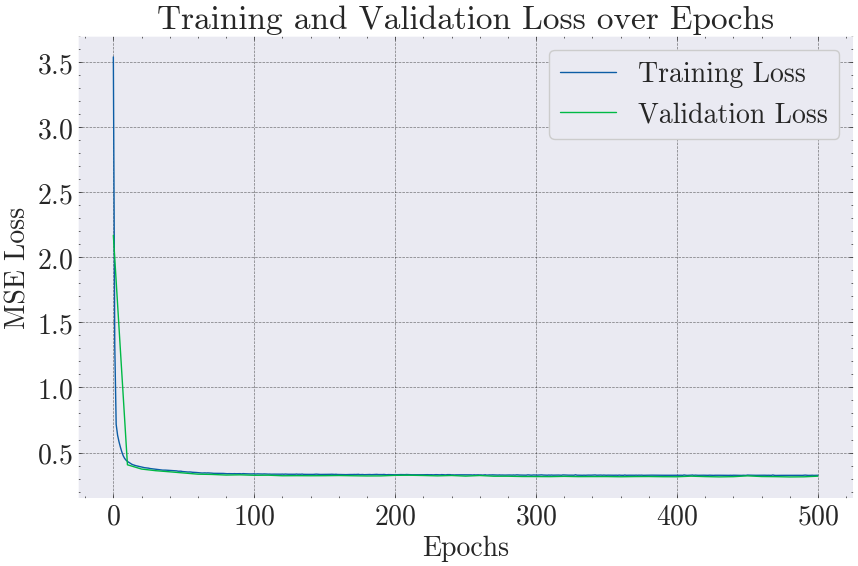

In [13]:
# plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(range(0, len(history['val_loss'])*10, 10), history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [18]:
# Linear regression of the same data for comparison
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lin_reg = LinearRegression()
lin_reg.fit(X, Y)
Y_pred_lin = lin_reg.predict(X)
mse_lin = mean_squared_error(Y, Y_pred_lin)
print(f'Linear Regression Test MSE Loss: {mse_lin:.4f}')

Linear Regression Test MSE Loss: 0.5243


In [16]:
# compare NN results to linear regression in table
import pandas as pd
results_df = pd.DataFrame({
    'Model': ['Neural Network', 'Linear Regression'],
    'Test MSE Loss': [test_loss.item(), mse_lin]
})
print(results_df)

               Model  Test MSE Loss
0     Neural Network       0.331371
1  Linear Regression       0.524321


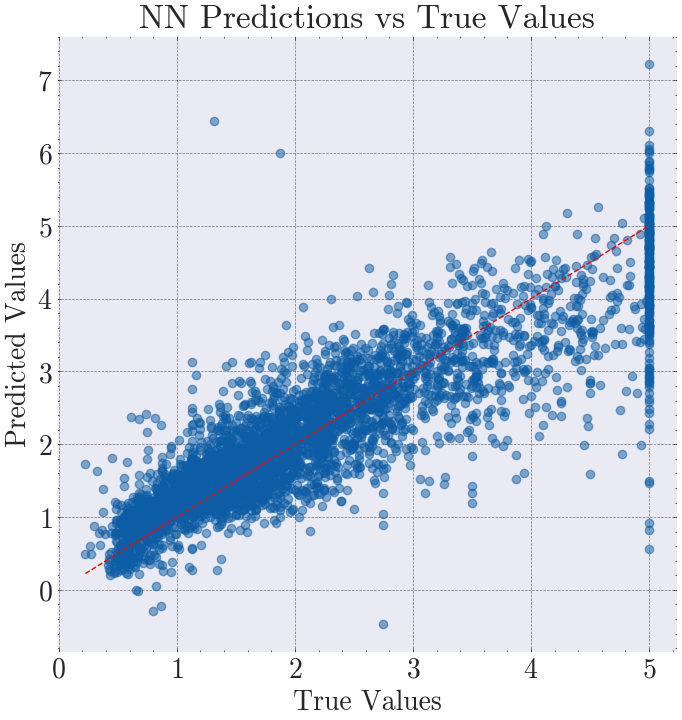

In [19]:
# plot NN predictions vs true values
plt.figure(figsize=(8,8))
plt.scatter(Y_test, Y_pred.cpu().numpy(), alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('NN Predictions vs True Values')
plt.show()

In [20]:
# compare different architectures, learning rates, batch sizes
architectures = [[16, 16], [32, 16], [32, 64, 16]]
learning_rates = [0.01, 0.001, 0.0001]
results = []
for arch in architectures:
    for lr in learning_rates:
        layers = [nn.Linear(input_size,arch[0]), nn.ReLU()]
        for i,layer in enumerate(arch):
            if i < len(arch) - 1:
                layers.append(nn.Linear(layer, arch[i+1]))
                layers.append(nn.ReLU())
        layers.append(nn.Linear(arch[-1], output_size))
        model = nn.Sequential(*layers).to(device)
        print(f'Training model with architecture: {arch}, learning rate: {lr}')
        history = train_model(model, X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val, 
                                num_epochs=200, learning_rate=lr, batch_size=64)
        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
            Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device).view(-1, 1)
            Y_pred = model(X_test_tensor)
            test_loss = nn.MSELoss()(Y_pred, Y_test_tensor)
        results.append({
            'Architecture': str(arch),
            'Learning Rate': lr,
            'Test MSE Loss': test_loss.item()
        })

results_df = pd.DataFrame(results)
print(results_df)

Training model with architecture: [16, 16], learning rate: 0.01
Epoch [0/200], Train Loss: 0.6723, Val Loss: 0.3986
Epoch [10/200], Train Loss: 0.3501, Val Loss: 0.3311
Epoch [20/200], Train Loss: 0.3206, Val Loss: 0.3077
Epoch [30/200], Train Loss: 0.3156, Val Loss: 0.3083
Epoch [40/200], Train Loss: 0.3030, Val Loss: 0.3201
Epoch [50/200], Train Loss: 0.3003, Val Loss: 0.3056
Epoch [60/200], Train Loss: 0.2899, Val Loss: 0.2970
Epoch [70/200], Train Loss: 0.2910, Val Loss: 0.2931
Epoch [80/200], Train Loss: 0.2938, Val Loss: 0.2863
Epoch [90/200], Train Loss: 0.2826, Val Loss: 0.2836
Epoch [100/200], Train Loss: 0.2820, Val Loss: 0.2789
Epoch [110/200], Train Loss: 0.2785, Val Loss: 0.2888
Epoch [120/200], Train Loss: 0.2897, Val Loss: 0.2889
Epoch [130/200], Train Loss: 0.2907, Val Loss: 0.2892
Epoch [140/200], Train Loss: 0.2781, Val Loss: 0.2798
Epoch [150/200], Train Loss: 0.2763, Val Loss: 0.2811
Epoch [160/200], Train Loss: 0.2722, Val Loss: 0.2761
Epoch [170/200], Train Loss: 

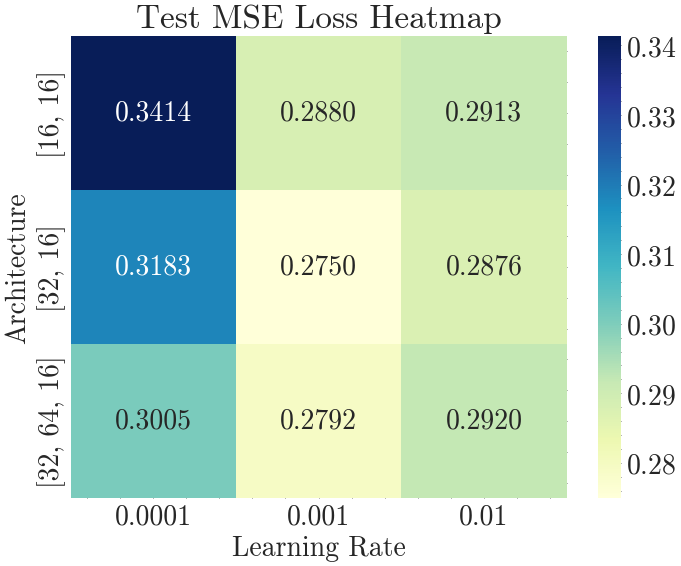

In [21]:
# visualize comparisons in a 3x3 heatchart (x axis : learning rates, y axis: architectures) color coded by test mse loss
pivot_table = results_df.pivot(index='Architecture', columns='Learning Rate', values='Test MSE Loss')
plt.figure(figsize=(8,6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")

plt.title("Test MSE Loss Heatmap")
plt.show()

In [22]:
architectures = [[32,16], [32,64,16], [8,512,8], [16,16,16], [16,16,16,16,16,16,16], [32,4,32],[16,1,16]]
learning_rate = 0.001

results = []
histories = {}
for arch in architectures:
    layers = [nn.Linear(input_size,arch[0]), nn.ReLU()]
    for i,layer in enumerate(arch):
        if i < len(arch) - 1:
            layers.append(nn.Linear(layer, arch[i+1]))
            layers.append(nn.ReLU())
    layers.append(nn.Linear(arch[-1], output_size))
    model = nn.Sequential(*layers).to(device)
    print(f'Training model with architecture: {arch}')
    history = train_model(model, X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val, 
                            num_epochs=200, learning_rate=learning_rate, batch_size=64)
    histories[str(arch)] = history
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device).view(-1, 1)
        Y_pred = model(X_test_tensor)
        test_loss = nn.MSELoss()(Y_pred, Y_test_tensor)
    results.append({
        'Architecture': str(arch),
        'Learning Rate': learning_rate,
        'Test MSE Loss': test_loss.item()
    })

results_df = pd.DataFrame(results)
print(results_df)

Training model with architecture: [32, 16]
Epoch [0/200], Train Loss: 1.8946, Val Loss: 0.6848
Epoch [10/200], Train Loss: 0.3670, Val Loss: 0.3504
Epoch [20/200], Train Loss: 0.3221, Val Loss: 0.3112
Epoch [30/200], Train Loss: 0.3010, Val Loss: 0.2926
Epoch [40/200], Train Loss: 0.2932, Val Loss: 0.2926
Epoch [50/200], Train Loss: 0.2871, Val Loss: 0.2851
Epoch [60/200], Train Loss: 0.2814, Val Loss: 0.2784
Epoch [70/200], Train Loss: 0.2754, Val Loss: 0.2759
Epoch [80/200], Train Loss: 0.2704, Val Loss: 0.2725
Epoch [90/200], Train Loss: 0.2663, Val Loss: 0.2733
Epoch [100/200], Train Loss: 0.2646, Val Loss: 0.2679
Epoch [110/200], Train Loss: 0.2610, Val Loss: 0.2681
Epoch [120/200], Train Loss: 0.2592, Val Loss: 0.2678
Epoch [130/200], Train Loss: 0.2572, Val Loss: 0.2688
Epoch [140/200], Train Loss: 0.2556, Val Loss: 0.2717
Epoch [150/200], Train Loss: 0.2566, Val Loss: 0.2652
Epoch [160/200], Train Loss: 0.2530, Val Loss: 0.2668
Epoch [170/200], Train Loss: 0.2534, Val Loss: 0.2

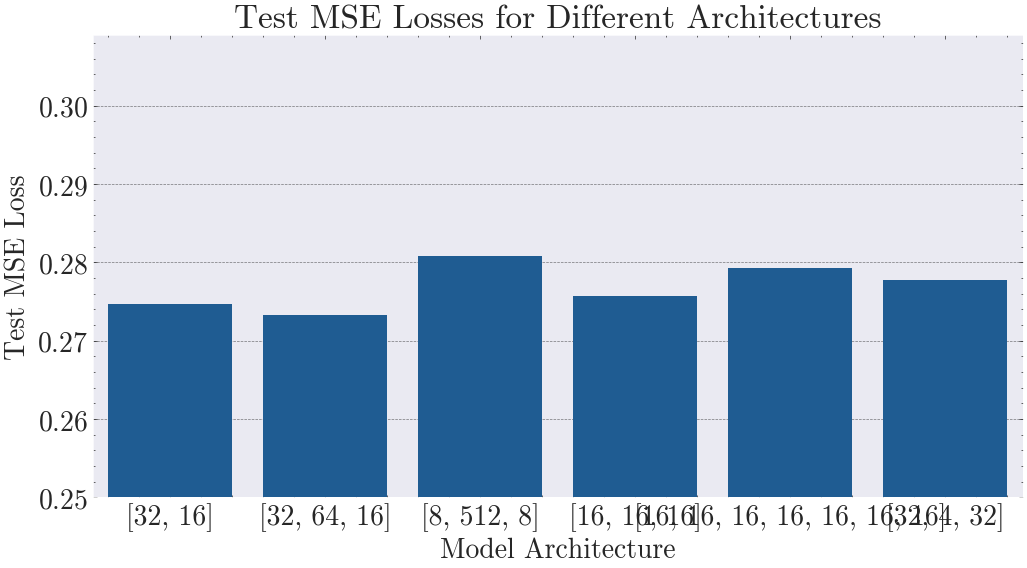

In [ ]:
# bar graph of test mse losses for different architectures using results_df ignoring [16,1,16]
mse_losses = results_df['Test MSE Loss'].values[:-1]
architectures_str = results_df['Architecture'].values[:-1]
plt.figure(figsize=(18,6))
sns.barplot(x=architectures_str, y=mse_losses)
plt.xlabel('Model Architecture')
plt.ylabel('Test MSE Loss')
plt.ylim(0.25, max(mse_losses)*1.1)
plt.title('Test MSE Losses for Different Architectures')
plt.show()

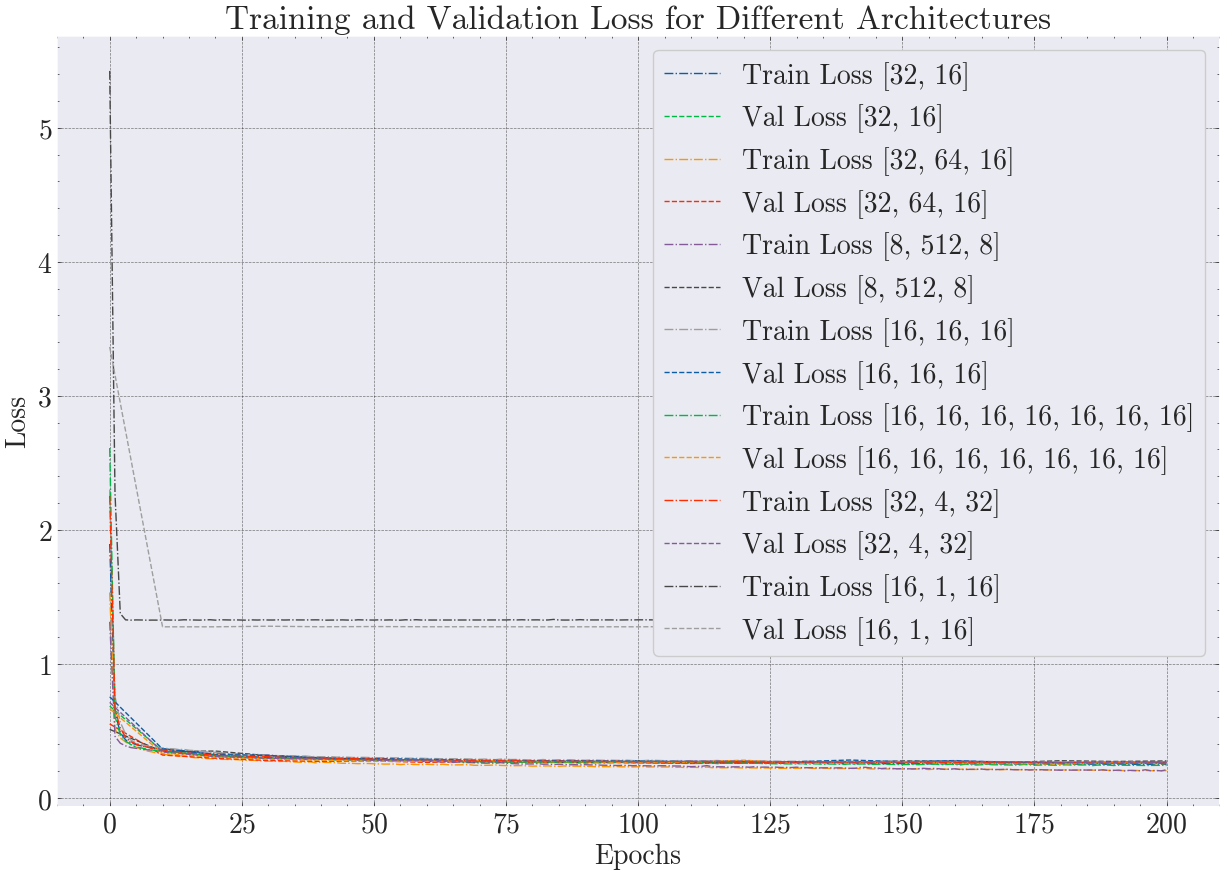

In [36]:
# plot training and validation loss for different architectures
plt.figure(figsize=(15,10))
for arch, history in histories.items():
    val_dict = {i*10: v for i, v in enumerate(history['val_loss'])}
    plt.plot(range(len(history['train_loss'])), history['train_loss'], label=f'Train Loss {arch}', linestyle='-.')
    plt.plot(list(val_dict.keys()), list(val_dict.values()), label=f'Val Loss {arch}', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Architectures')
plt.legend()
plt.show()